# What is `torch.nn` really?
Source: https://pytorch.org/tutorials/beginner/nn_tutorial.html

Links:
 - Exp normalization trick : https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
 - Why log probabilities: https://stats.stackexchange.com/questions/289369/log-probabilities-in-reference-to-softmax-classifier
 - Understanding softmax and NLLL: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
 


In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path('../../data')
PATH = DATA_PATH / "mnist"

In [3]:
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

In [5]:
if not (PATH/FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH/FILENAME).open("wb").write(content)

In [6]:
import pickle
import gzip

In [7]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin1')

In [8]:
x_train.shape, y_train.shape

((50000, 784), (50000,))

In [9]:
import matplotlib.pyplot as plt
import numpy as np

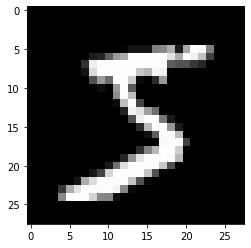

In [10]:
plt.imshow(x_train[0].reshape(28,28), cmap="gray")
plt.show()

In [11]:
import torch

In [12]:
x_train, y_train, x_valid, y_valid = map(torch.from_numpy, [x_train, y_train, x_valid, y_valid])

## Neural net from scratch

In [13]:
import math

weights = torch.randn((784,10)) / math.sqrt(784)
weights.requires_grad_()
bias = torch.randn(10, requires_grad=True)

In [14]:
weights.shape

torch.Size([784, 10])

In [124]:
def log_softmax(x):
    # This is a faster implementation of log(softmax(x))
    # Also see:
    # Why log probabilities: https://stats.stackexchange.com/questions/289369/log-probabilities-in-reference-to-softmax-classifier
    # NLLL implementation: https://forums.fast.ai/t/nllloss-implementation/20028
    # Exp normalization trick : https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(x):
    return log_softmax(x@weights + bias)

In [20]:
bs = 64

xb = x_train[:bs]
yb = y_train[:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-3.6831, -4.9580, -3.9216, -2.8816, -3.8615, -0.9923, -0.9579, -4.8391,
        -4.0235, -2.3999], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [21]:
def nll(input, target):
    # Understanding softmax and NLLL
    # https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
    x = range(target.shape[0])
    return -input[x, target].mean()

loss_func = nll

In [22]:
loss_func(preds, yb)

tensor(3.1481, grad_fn=<NegBackward>)

In [23]:
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return (preds == labels).float().mean()

In [24]:
accuracy(preds, yb)

tensor(0.0625)

In [25]:
from IPython.core.debugger import set_trace

In [26]:
lr = 0.5
epochs = 2
n, c = x_train.shape

for epoch in range(epochs):
    for i in range((n-1) // (bs + 1)):
        start = bs * i 
        end = start + bs
        
        x_b, y_b = x_train[start:end], y_train[start:end]
        preds = model(x_b)
        loss = loss_func(preds, y_b)
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            weights.grad.zero_()
            
            bias -= bias.grad * lr
            bias.grad.zero_()

In [27]:
preds = model(xb)
loss_func(preds, yb), accuracy(preds, yb)

(tensor(0.1538, grad_fn=<NegBackward>), tensor(0.9688))

## Using `torch.nn.functional`

In [28]:
import torch.nn.functional as F

In [32]:
loss_func = F.cross_entropy

In [33]:
def model(x):
    return x @ weights + bias

In [35]:
preds = model(xb)
print(loss_func(preds, yb), accuracy(preds, yb))

tensor(0.1538, grad_fn=<NllLossBackward>) tensor(0.9688)


## Refactor using `nn.Module`

nn.Parameter vs. Variable :  https://discuss.pytorch.org/t/what-is-the-difference-between-autograd-variable-and-nn-parameter/35934/2

- Parameters that are inside of a module are added to the list of Module parameters. 
- If m is your module m.parameters() will hold your parameter.
- Also, note that Parameters have `require_grad` set by default.


In [36]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [37]:
model = Mnist_Logistic()

In [40]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3019, grad_fn=<NllLossBackward>) tensor(0.1094)


In [41]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // (bs + 1)):
            start = bs * i 
            end = start + bs

            x_batch, y_batch = x_train[start:end], y_train[start:end]
            preds = model(x_batch)
            loss = loss_func(preds, y_batch)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [42]:
fit()

In [43]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1508, grad_fn=<NllLossBackward>) tensor(0.9688)


## Refactor using `optim`

In [44]:
from torch import optim

In [46]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.4452, grad_fn=<NllLossBackward>) tensor(0.0312)


In [47]:
for epoch in range(epochs):
    for i in range((n-1) // (bs + 1)):
        start = bs * i 
        end = start + bs

        x_batch, y_batch = x_train[start:end], y_train[start:end]
        preds = model(x_batch)
        
        loss = loss_func(preds, y_batch)
        loss.backward()
        
        opt.step()
        opt.zero_grad()

In [48]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1556, grad_fn=<NllLossBackward>) tensor(0.9688)


## Refactor using `Dataset`

In [49]:
from torch.utils.data import TensorDataset

In [50]:
train_ds = TensorDataset(x_train, y_train)

In [51]:
for epoch in range(epochs):
    for i in range((n-1) // (bs + 1)):
        x_batch, y_batch = train_ds[i*bs:(i+1)*bs]
        preds = model(x_batch)
        
        loss = loss_func(preds, y_batch)
        loss.backward()
        
        opt.step()
        opt.zero_grad()

In [52]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1326, grad_fn=<NllLossBackward>) tensor(0.9688)


## Refactor using `Dataloader`

In [53]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [54]:
for epoch in range(epochs):
    for (x_batch, y_batch) in train_dl:
        preds = model(x_batch)
        
        loss = loss_func(preds, y_batch)
        loss.backward()
        
        opt.step()
        opt.zero_grad()

In [55]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1864, grad_fn=<NllLossBackward>) tensor(0.9375)


## Adding validation

In [56]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [57]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3337)
1 tensor(0.3751)


## Create `fit` and `get_data`

In [58]:
def loss_batch(model, loss_function, xb, yb, opt=None):
    loss = loss_function(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(yb)

In [59]:
a = zip((1,2),(3,4))
list(a)

[(1, 3), (2, 4)]

In [82]:
def fit(epochs, model, loss_function, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_function, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_function, xb, yb) for xb, yb in train_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(f"Epoch: {epoch}, Val Loss: {val_loss}")

In [64]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [65]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch:1, Val Loss: 0.30955918073654176
Epoch:1, Val Loss: 0.2956622120571136


## Switch to CNN

In [73]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [83]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Val Loss: 0.4302718688416481
Epoch: 1, Val Loss: 0.2880231401634216


## `nn.Sequential`

In [84]:
class Lambda(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, x):
        return self.f(x)

In [85]:
model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.shape[0], -1))
    )

In [86]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Val Loss: 0.4808979358863831
Epoch: 1, Val Loss: 0.28049195108890534


## Wrapping DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:

- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that’s the average

In [88]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

In [122]:
class WrappedDataLoader:
    
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batch = iter(self.dl)
        for x, y in batch:
            yield self.func(x, y)

In [105]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

In [106]:
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [107]:
# What is AdaptiveAvgPool: https://discuss.pytorch.org/t/what-is-adaptiveavgpool2d/26897/2

In [108]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [109]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [110]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Val Loss: 0.3841371780014038
Epoch: 1, Val Loss: 0.30383498945236204


## Using GPU

In [112]:
print(torch.cuda.is_available())

False


In [114]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [117]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [118]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [119]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Val Loss: 0.24742591617584228
Epoch: 1, Val Loss: 0.21743569037914276


## Summary

- **torch.nn**
    - `Module`: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what `Parameter(s)` it contains and can zero all their gradients, loop through them for weight updates, etc.
    - `Parameter`: a wrapper for a tensor that tells a `Module` that it has weights that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
    - `functional`: a module(usually imported into the `F` namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.
   
   
- `torch.optim`: Contains optimizers such as `SGD`, which update the weights of `Parameter` during the backward step

- `Dataset`: An abstract interface of objects with a `__len__` and a `__getitem__`, including classes provided with Pytorch such as `TensorDataset`

- `DataLoader`: Takes any `Dataset` and creates an iterator which returns batches of data.

## Extras

### Weight Initialization after model definition

In [133]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

model = Mnist_CNN()
model.apply(weight_init)

Mnist_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

In [134]:
for p in model.parameters():
    print(p.grad)

None
None
None
None
None
None
